# Revenue by Channel Visualization Plan

## Major Assumptions
Channel attribution data exists in the Thatch database linking employers to their acquisition channels (direct sales, broker, payroll partner). MRR can be calculated from employer subscription data and aggregated by channel. The visualization should be presentation-ready with clear comparisons across channels.

## Plan
- [x] Extract and join employer revenue data with channel attribution
  - [x] Query employers table joined with channel_attribution to get channel assignments
  - [x] Calculate MRR for each employer and aggregate by channel
- [x] Create polished revenue by channel visualization
  - [x] Design clear bar chart showing MRR distribution across direct sales, broker, and payroll partner channels
  - [x] Add formatting, labels, and annotations for presentation quality

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sqlalchemy import create_engine

# SignalPilot dark theme
plt.rcParams.update({
    'figure.figsize': (10, 6), 'figure.dpi': 100, 'savefig.dpi': 300,
    'font.size': 11, 'axes.titlesize': 14, 'axes.labelsize': 12,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 10,
    'axes.spines.top': False, 'axes.spines.right': False,
    'figure.facecolor': '#08070e', 'axes.facecolor': '#12101e',
    'axes.edgecolor': '#272336', 'axes.labelcolor': '#e9eaeb',
    'text.color': '#FAFAFA', 'xtick.color': '#a4a7ae', 'ytick.color': '#a4a7ae',
    'grid.color': '#1d182b', 'legend.facecolor': '#12101e',
    'legend.edgecolor': '#272336', 'legend.labelcolor': '#e9eaeb',
    'savefig.facecolor': '#08070e',
})
COLORS = {'primary': '#c4b5fd', 'secondary': '#ff8dc4', 'tertiary': '#8b5cf6'}
CATEGORICAL_PALETTE = ['#c4b5fd', '#ff8dc4', '#8b5cf6', '#73acfb', '#fec163', '#4ca86f']

# Connect to Thatch database
engine = create_engine(os.environ['THATCH_CONNECTION_URL'])

# Query: Join employers with channel attribution, calculate MRR by channel
query = """
SELECT 
    ca.channel,
    COUNT(DISTINCT e.id) AS employer_count,
    SUM(e.employee_count) AS total_employees,
    SUM(e.employee_count * e.pepm_fee_usd) AS monthly_revenue
FROM employers e
JOIN channel_attribution ca ON e.id = ca.employer_id
WHERE e.status = 'active'
GROUP BY ca.channel
ORDER BY monthly_revenue DESC
"""

df = pd.read_sql(query, engine)
engine.dispose()

# Format channel names for display
channel_labels = {
    'direct_sales': 'Direct Sales',
    'broker': 'Broker',
    'payroll_partner': 'Payroll Partner'
}
df['channel_label'] = df['channel'].map(channel_labels)
df['revenue_k'] = df['monthly_revenue'] / 1000

df

,channel,employer_count,total_employees,monthly_revenue,channel_label,revenue_k
0,direct_sales,116,6618,1391491.58,Direct Sales,1391.49158
1,broker,133,5202,976816.20,Broker,976.81620
2,payroll_partner,102,5428,935735.01,Payroll Partner,935.73501


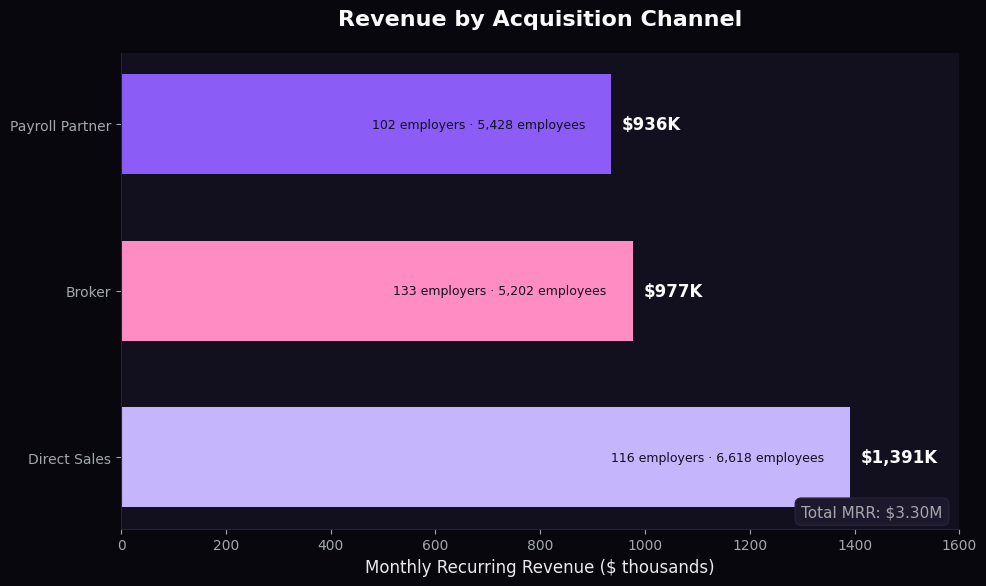

In [2]:
fig, ax = plt.subplots(figsize=(10, 6))

# Horizontal bar chart for revenue by channel
bars = ax.barh(df['channel_label'], df['revenue_k'], color=CATEGORICAL_PALETTE[:3], height=0.6)

# Add value labels
for bar, val, emp_count, employers in zip(bars, df['revenue_k'], df['total_employees'], df['employer_count']):
    ax.text(val + 20, bar.get_y() + bar.get_height()/2, 
            f'${val:,.0f}K', va='center', fontsize=12, fontweight='bold', color='#FAFAFA')
    ax.text(val - 50, bar.get_y() + bar.get_height()/2, 
            f'{employers} employers · {emp_count:,} employees', va='center', ha='right', 
            fontsize=9, color='#12101e', fontweight='medium')

ax.set_xlabel('Monthly Recurring Revenue ($ thousands)', fontweight='medium')
ax.set_title('Revenue by Acquisition Channel', fontweight='bold', pad=20, fontsize=16)
ax.set_xlim(0, df['revenue_k'].max() * 1.15)

# Add total annotation
total_mrr = df['monthly_revenue'].sum()
ax.text(0.98, 0.02, f'Total MRR: ${total_mrr/1e6:.2f}M', transform=ax.transAxes,
        ha='right', va='bottom', fontsize=11, color='#a4a7ae',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='#1d182b', edgecolor='#272336'))

plt.tight_layout()
plt.show()

In [3]:
# Employee activation rate: % of eligible employees who selected a plan
query_activation = """
SELECT 
    enrollment_status,
    COUNT(*) AS employee_count
FROM employees emp
JOIN employers er ON emp.employer_id = er.id
WHERE er.status = 'active'
GROUP BY enrollment_status
ORDER BY employee_count DESC
"""

df_status = pd.read_sql(query_activation, create_engine(os.environ['THATCH_CONNECTION_URL']))

# Calculate activation rate (active / (active + eligible))
active = df_status[df_status['enrollment_status'] == 'active']['employee_count'].values[0]
eligible = df_status[df_status['enrollment_status'] == 'eligible']['employee_count'].values[0]
total_addressable = active + eligible
activation_rate = active / total_addressable * 100

df_status['percentage'] = df_status['employee_count'] / df_status['employee_count'].sum() * 100
df_status

,enrollment_status,employee_count,percentage
0,active,3784,73.532841
1,eligible,831,16.148465
2,terminated,316,6.140692
3,waived,215,4.178002


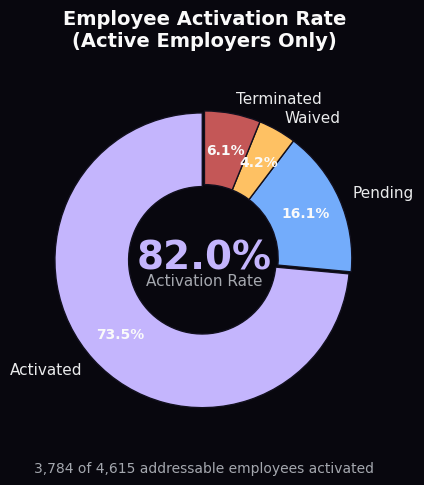

In [4]:
fig, ax = plt.subplots(figsize=(8, 5))

# Donut chart for activation funnel
labels = ['Activated', 'Pending', 'Waived', 'Terminated']
sizes = [active, eligible, 
         df_status[df_status['enrollment_status'] == 'waived']['employee_count'].values[0],
         df_status[df_status['enrollment_status'] == 'terminated']['employee_count'].values[0]]
colors = [COLORS['primary'], '#73acfb', '#fec163', '#c45757']
explode = (0.02, 0, 0, 0)

wedges, texts, autotexts = ax.pie(sizes, explode=explode, labels=labels, colors=colors,
                                   autopct='%1.1f%%', startangle=90, pctdistance=0.75,
                                   wedgeprops=dict(width=0.5, edgecolor='#12101e'))

for autotext in autotexts:
    autotext.set_color('#FAFAFA')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')
for text in texts:
    text.set_color('#e9eaeb')
    text.set_fontsize(11)

# Center text with activation rate
ax.text(0, 0, f'{activation_rate:.1f}%', ha='center', va='center', 
        fontsize=28, fontweight='bold', color=COLORS['primary'])
ax.text(0, -0.15, 'Activation Rate', ha='center', va='center', 
        fontsize=11, color='#a4a7ae')

ax.set_title('Employee Activation Rate\n(Active Employers Only)', fontweight='bold', pad=20, fontsize=14)

# Add count annotation
ax.text(0.5, -0.08, f'{active:,} of {total_addressable:,} addressable employees activated', 
        transform=ax.transAxes, ha='center', fontsize=10, color='#a4a7ae')

plt.tight_layout()
plt.show()

In [5]:
# Debit card spend analysis
engine = create_engine(os.environ['THATCH_CONNECTION_URL'])

# Average spend per member
query_avg = """
SELECT 
    COUNT(DISTINCT employee_id) AS unique_members,
    COUNT(*) AS total_transactions,
    SUM(amount_usd) AS total_spend,
    AVG(amount_usd) AS avg_transaction,
    SUM(amount_usd) / COUNT(DISTINCT employee_id) AS avg_spend_per_member
FROM debit_transactions
"""
df_avg = pd.read_sql(query_avg, engine)

# Spend by category
query_cat = """
SELECT 
    merchant_category,
    COUNT(*) AS transactions,
    SUM(amount_usd) AS total_spend,
    AVG(amount_usd) AS avg_transaction
FROM debit_transactions
GROUP BY merchant_category
ORDER BY total_spend DESC
"""
df_cat = pd.read_sql(query_cat, engine)
engine.dispose()

df_cat['pct_of_total'] = df_cat['total_spend'] / df_cat['total_spend'].sum() * 100
df_cat['category_label'] = df_cat['merchant_category'].str.replace('_', ' ').str.title()

print(f"Unique members with card activity: {df_avg['unique_members'].values[0]:,}")
print(f"Average spend per member: ${df_avg['avg_spend_per_member'].values[0]:,.2f}")
print(f"Total spend: ${df_avg['total_spend'].values[0]:,.2f}")
df_cat.head(10)

Unique members with card activity: 3,672
Average spend per member: $2,674.18
Total spend: $9,819,574.29


,merchant_category,transactions,total_spend,avg_transaction,pct_of_total,category_label
0,hospital,1848,1905682.17,1031.213295,19.406973,Hospital
1,medical_office,3895,1311738.67,336.775012,13.358407,Medical Office
2,pharmacy_retail,2743,1171202.30,426.978600,11.927221,Pharmacy Retail
3,dental_clinic,2095,1136351.70,542.411313,11.572311,Dental Clinic
4,pharmacy_mail_order,1270,989103.93,778.821992,10.072778,Pharmacy Mail Order
5,mental_health_provider,907,524418.67,578.190375,5.340544,Mental Health Provider
6,vision_care,905,516306.82,570.504773,5.257935,Vision Care
7,urgent_care,1075,514017.35,478.155674,5.234619,Urgent Care
8,lab_testing,726,357246.21,492.074669,3.638103,Lab Testing
9,orthodontics,524,336584.46,642.336756,3.427689,Orthodontics


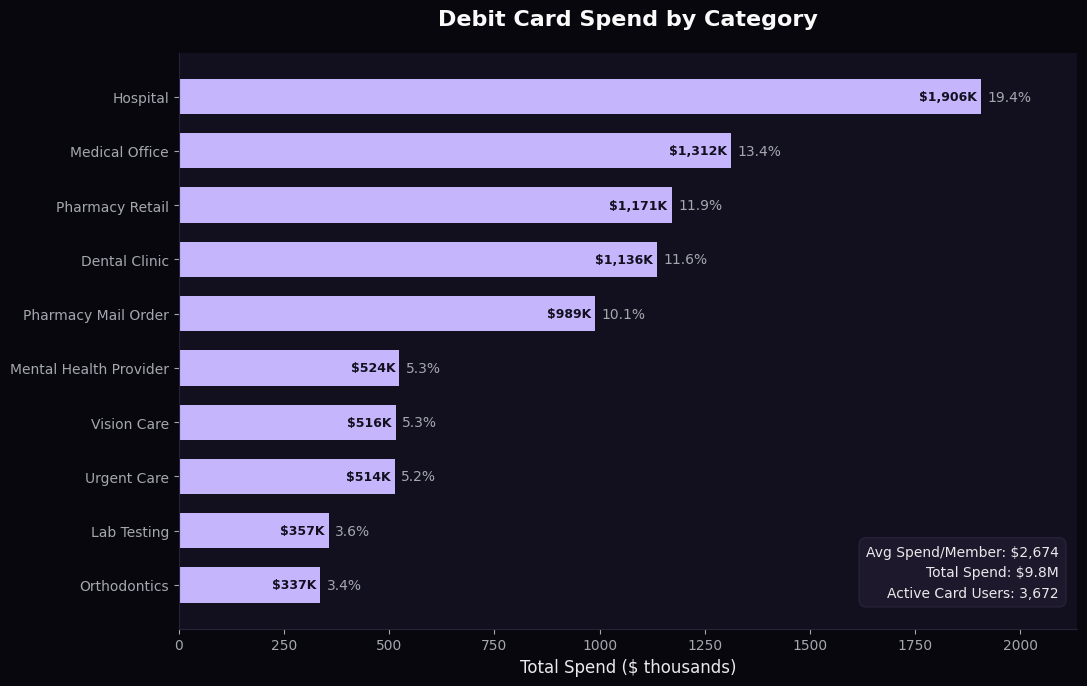

In [6]:
fig, ax = plt.subplots(figsize=(11, 7))

# Top 10 categories horizontal bar
top_cats = df_cat.head(10).iloc[::-1]  # Reverse for horizontal bar
bars = ax.barh(top_cats['category_label'], top_cats['total_spend'] / 1000, 
               color=COLORS['primary'], height=0.65)

# Add value labels
for bar, pct, avg in zip(bars, top_cats['pct_of_total'].values, top_cats['avg_transaction'].values):
    ax.text(bar.get_width() + 15, bar.get_y() + bar.get_height()/2, 
            f'{pct:.1f}%', va='center', fontsize=10, color='#a4a7ae')
    ax.text(bar.get_width() - 10, bar.get_y() + bar.get_height()/2, 
            f'${bar.get_width():,.0f}K', va='center', ha='right', 
            fontsize=9, fontweight='bold', color='#12101e')

ax.set_xlabel('Total Spend ($ thousands)', fontweight='medium')
ax.set_title('Debit Card Spend by Category', fontweight='bold', pad=20, fontsize=16)
ax.set_xlim(0, top_cats['total_spend'].max() / 1000 * 1.12)

# Key metrics annotation
metrics_text = f"Avg Spend/Member: ${df_avg['avg_spend_per_member'].values[0]:,.0f}\nTotal Spend: ${df_avg['total_spend'].values[0]/1e6:.1f}M\nActive Card Users: {df_avg['unique_members'].values[0]:,}"
ax.text(0.98, 0.05, metrics_text, transform=ax.transAxes, ha='right', va='bottom',
        fontsize=10, color='#e9eaeb', linespacing=1.6,
        bbox=dict(boxstyle='round,pad=0.5', facecolor='#1d182b', edgecolor='#272336'))

plt.tight_layout()
plt.show()

In [7]:
# NRR by employer size: compare initial vs current employee counts
engine = create_engine(os.environ['THATCH_CONNECTION_URL'])

# Get initial and current employee counts per employer
query_nrr = """
WITH employer_metrics AS (
    SELECT 
        e.id AS employer_id,
        e.company_name,
        e.employee_count AS current_count,
        e.pepm_fee_usd,
        e.contract_start::date,
        e.status,
        -- Count employees added in first 30 days as "initial"
        COUNT(CASE WHEN emp.created_at::date <= e.contract_start::date + INTERVAL '30 days' 
                   AND emp.enrollment_status != 'terminated' THEN 1 END) AS initial_count,
        -- Current active employees
        COUNT(CASE WHEN emp.enrollment_status IN ('active', 'eligible', 'waived') THEN 1 END) AS current_active
    FROM employers e
    LEFT JOIN employees emp ON e.id = emp.employer_id
    WHERE e.status = 'active'
    GROUP BY e.id, e.company_name, e.employee_count, e.pepm_fee_usd, e.contract_start, e.status
)
SELECT 
    employer_id,
    company_name,
    current_count,
    pepm_fee_usd,
    contract_start,
    initial_count,
    current_active,
    CASE 
        WHEN initial_count > 0 THEN ROUND(current_active * 100.0 / initial_count, 1)
        ELSE 100.0 
    END AS nrr_pct,
    -- Size bucket based on current employee count
    CASE 
        WHEN current_count <= 10 THEN '1-10'
        WHEN current_count <= 25 THEN '11-25'
        WHEN current_count <= 50 THEN '26-50'
        WHEN current_count <= 100 THEN '51-100'
        ELSE '100+'
    END AS size_bucket
FROM employer_metrics
WHERE initial_count > 0
ORDER BY current_count DESC
"""
df_nrr = pd.read_sql(query_nrr, engine)
engine.dispose()

# Summary by size bucket
nrr_by_size = df_nrr.groupby('size_bucket').agg(
    employers=('employer_id', 'count'),
    avg_nrr=('nrr_pct', 'mean'),
    median_nrr=('nrr_pct', 'median'),
    total_initial=('initial_count', 'sum'),
    total_current=('current_active', 'sum')
).reset_index()

# Calculate weighted NRR
nrr_by_size['weighted_nrr'] = nrr_by_size['total_current'] / nrr_by_size['total_initial'] * 100

# Order size buckets
size_order = ['1-10', '11-25', '26-50', '51-100', '100+']
nrr_by_size['size_bucket'] = pd.Categorical(nrr_by_size['size_bucket'], categories=size_order, ordered=True)
nrr_by_size = nrr_by_size.sort_values('size_bucket')

nrr_by_size

,size_bucket,employers,avg_nrr,median_nrr,total_initial,total_current,weighted_nrr
0,1-10,71,194.130986,200.0,98,172,175.510204
2,11-25,78,211.471795,150.0,189,319,168.783069
3,26-50,62,224.091935,184.5,341,648,190.029326
4,51-100,37,245.464865,192.9,355,713,200.845070
1,100+,64,211.732812,201.7,1415,2899,204.876325


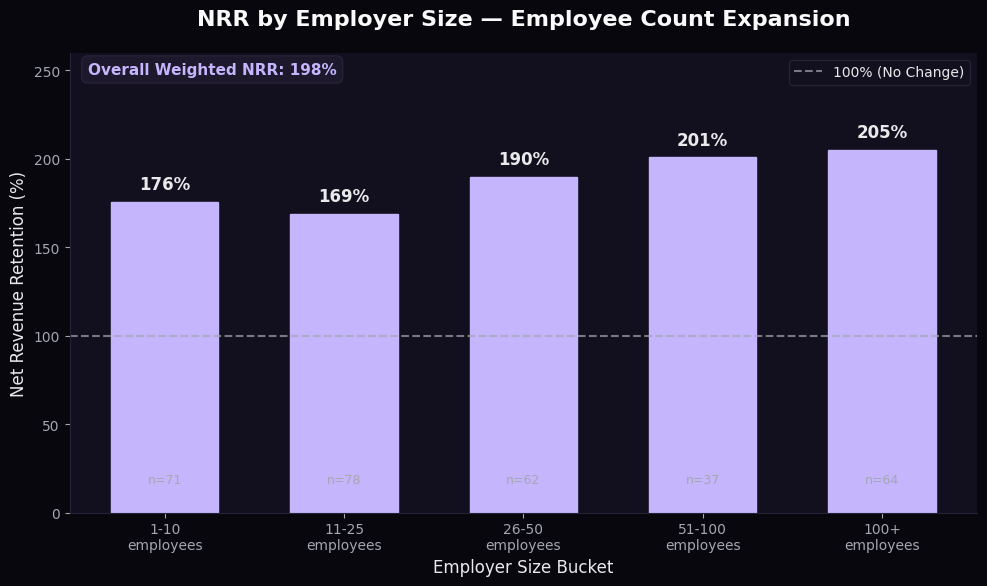

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

x = range(len(nrr_by_size))
bars = ax.bar(x, nrr_by_size['weighted_nrr'], color=COLORS['primary'], width=0.6, 
              edgecolor='#272336', linewidth=1)

# Add 100% reference line
ax.axhline(y=100, color='#a4a7ae', linestyle='--', linewidth=1.5, alpha=0.7, label='100% (No Change)')

# Color bars above 100% 
for bar in bars:
    if bar.get_height() > 100:
        bar.set_color(COLORS['primary'])
    else:
        bar.set_color(COLORS['red'])

# Value labels
for bar, nrr, emp in zip(bars, nrr_by_size['weighted_nrr'], nrr_by_size['employers']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
            f'{nrr:.0f}%', ha='center', va='bottom', fontsize=12, fontweight='bold', color='#e9eaeb')
    ax.text(bar.get_x() + bar.get_width()/2, 15, 
            f'n={emp}', ha='center', va='bottom', fontsize=9, color='#a4a7ae')

ax.set_xticks(x)
ax.set_xticklabels(nrr_by_size['size_bucket'].astype(str) + '\nemployees')
ax.set_ylabel('Net Revenue Retention (%)', fontweight='medium')
ax.set_xlabel('Employer Size Bucket', fontweight='medium')
ax.set_title('NRR by Employer Size — Employee Count Expansion', fontweight='bold', pad=20, fontsize=16)
ax.set_ylim(0, 260)
ax.legend(loc='upper right', framealpha=0.9)

# Overall NRR annotation
overall_nrr = df_nrr['current_active'].sum() / df_nrr['initial_count'].sum() * 100
ax.text(0.02, 0.98, f'Overall Weighted NRR: {overall_nrr:.0f}%', transform=ax.transAxes, 
        ha='left', va='top', fontsize=11, fontweight='bold', color=COLORS['primary'],
        bbox=dict(boxstyle='round,pad=0.4', facecolor='#1d182b', edgecolor='#272336'))

plt.tight_layout()
plt.show()